**<h2 style="text-align: center; color:#33FF33;">CHURN WITH NON PURCHASE USERS</h2>**

#### **Neccessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix, classification_report,
    confusion_matrix, roc_curve, auc,
    brier_score_loss
)
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Read and explore data**

#### **Read data**

In [2]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'},parse_dates=['last_update_time'])
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={'vopenid':'object'})
df_equip=pd.read_csv("../EDA_transform/data/equipenhance_transform_cluster.csv",dtype={'vopenid':'object'})

df_purchase.columns = df_purchase.columns.str.strip()
df_equip.columns = df_equip.columns.str.strip()
df_purchase['last_update_time'] = pd.to_datetime(df_purchase['last_update_time'], errors='coerce', utc=True)
df_equip['last_update_time'] = pd.to_datetime(df_equip['last_update_time'], errors='coerce', utc=True)

df_login.shape,df_purchase.shape,df_equip.shape

((199370, 17), (32120, 9), (55138, 10))

In [3]:
df_login.info(),df_login['last_update_time'].min(),df_login['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199370 entries, 0 to 199369
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   vopenid                199370 non-null  object             
 1   last_update_time       199370 non-null  datetime64[ns, UTC]
 2   num_day_login          199370 non-null  int64              
 3   avg_login_per_day      199370 non-null  float64            
 4   avg_between_login      199370 non-null  float64            
 5   streak_login           199370 non-null  int64              
 6   last_since_from_login  199370 non-null  int64              
 7   popular_time_login     199370 non-null  int64              
 8   gold_std_login         199370 non-null  float64            
 9   diamond_std_login      199370 non-null  float64            
 10  silkcoin_std_login     199370 non-null  float64            
 11  gold_slope_login       199370 non-null 

(None,
 Timestamp('2025-05-03 17:01:25+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

In [4]:
df_purchase.info(),df_purchase['last_update_time'].min(),df_purchase['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32120 entries, 0 to 32119
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   vopenid                   32120 non-null  object             
 1   last_update_time          32040 non-null  datetime64[ns, UTC]
 2   num_purchase              32120 non-null  int64              
 3   total_purchase            32120 non-null  float64            
 4   count_purchase_per_day    32120 non-null  float64            
 5   std_amount_purchase       32120 non-null  float64            
 6   max_purchase              32120 non-null  float64            
 7   days_since_last_purchase  32120 non-null  int64              
 8   num_product_buyed         32120 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(1)
memory usage: 2.2+ MB


(None,
 Timestamp('2025-05-03 17:06:56.892000+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:55.790000+0000', tz='UTC'))

In [5]:
df_equip.info(),df_equip['last_update_time'].min(),df_equip['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55138 entries, 0 to 55137
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   vopenid               55138 non-null  object             
 1   last_update_time      55138 non-null  datetime64[ns, UTC]
 2   num_enhance           55138 non-null  int64              
 3   enhance_success_rate  55138 non-null  float64            
 4   max_enhance_level     55138 non-null  int64              
 5   tsne_1                55138 non-null  float64            
 6   tsne_2                55138 non-null  float64            
 7   tsne_gmm_1            55138 non-null  float64            
 8   tsne_gmm_2            55138 non-null  float64            
 9   equi_beha             55138 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(2)
memory usage: 4.2+ MB


(None,
 Timestamp('2025-05-03 17:00:34+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:58+0000', tz='UTC'))

#### **Merge data**

In [6]:
df_login = df_login.rename(columns={'last_update_time': 'last_update_time_login'})
df_equip = df_equip.rename(columns={'last_update_time': 'last_update_time_equip'})
login_no_purchase = df_login[~df_login['vopenid'].isin(df_purchase['vopenid'])].copy()

df_merged = login_no_purchase.merge(
    df_equip[['vopenid', 'equi_beha']],
    on='vopenid',
    how='left'
)

In [7]:
del df_login
del df_purchase
del df_equip

In [8]:
df_merged.head(3)

,vopenid,last_update_time_login,num_day_login,avg_login_per_day,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,powerpoint_last_login,level_last_login,vip_last_login,equi_beha
0,2206111754266455,2025-05-08 11:08:20+00:00,2,1.00,1.02,2,39,10,12632.46,0.00,0.00,17865.00,0.00,0.00,29366,9,0,NaN
1,2206111758351763,2025-05-26 05:07:07+00:00,1,1.00,0.00,1,21,5,0.00,0.00,0.00,0.00,0.00,0.00,25359,1,0,NaN
2,2206111808105074,2025-06-16 02:01:16+00:00,2,3.00,0.09,2,0,1,191511.83,0.41,0.00,61253.34,-0.14,0.00,74275,21,0,normal


In [9]:
df_merged['equi_beha'] = df_merged['equi_beha'].fillna('not_enhance')

In [10]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167266 entries, 0 to 167265
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   vopenid                 167266 non-null  object             
 1   last_update_time_login  167266 non-null  datetime64[ns, UTC]
 2   num_day_login           167266 non-null  int64              
 3   avg_login_per_day       167266 non-null  float64            
 4   avg_between_login       167266 non-null  float64            
 5   streak_login            167266 non-null  int64              
 6   last_since_from_login   167266 non-null  int64              
 7   popular_time_login      167266 non-null  int64              
 8   gold_std_login          167266 non-null  float64            
 9   diamond_std_login       167266 non-null  float64            
 10  silkcoin_std_login      167266 non-null  float64            
 11  gold_slope_login        16

#### **Set churn**

In [11]:
now = pd.Timestamp('2025-06-19 17:00:00', tz='UTC')
df_merged['days_since_last_login'] = (now - df_merged['last_update_time_login']).dt.days

In [12]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-03 17:01:25+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

In [13]:
df_merged['churn'] = (df_merged['days_since_last_login'] >= 7).astype(int) # true is one
df_merged[['vopenid','last_update_time_login','churn']].head(10)

,vopenid,last_update_time_login,churn
0,2206111754266455,2025-05-08 11:08:20+00:00,1
1,2206111758351763,2025-05-26 05:07:07+00:00,1
2,2206111808105074,2025-06-16 02:01:16+00:00,0
3,2206111830413361,2025-06-18 00:44:14+00:00,0
4,2206111904162575,2025-05-20 01:58:44+00:00,1
5,2206112052180283,2025-06-18 15:20:53+00:00,0
6,2206112142566650,2025-06-18 16:46:53+00:00,0
7,2206120035016040,2025-06-15 02:48:53+00:00,0
8,2206121028161941,2025-06-08 18:53:35+00:00,1
9,2206121217018262,2025-06-11 09:53:41+00:00,1


In [14]:
df_merged['churn'].value_counts()

churn
1    87568
0    79698
Name: count, dtype: int64

In [15]:
df_merged.columns

Index(['vopenid', 'last_update_time_login', 'num_day_login',
       'avg_login_per_day', 'avg_between_login', 'streak_login',
       'last_since_from_login', 'popular_time_login', 'gold_std_login',
       'diamond_std_login', 'silkcoin_std_login', 'gold_slope_login',
       'diamond_slope_login', 'silkcoin_slope_login', 'powerpoint_last_login',
       'level_last_login', 'vip_last_login', 'equi_beha',
       'days_since_last_login', 'churn'],
      dtype='object')

#### **Visualize**

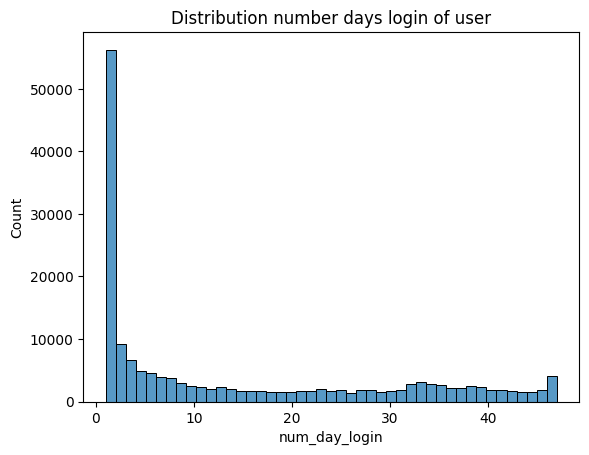

In [16]:
sns.histplot(df_merged['num_day_login'], bins=45)
plt.title('Distribution number days login of user')
plt.show()

In [17]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-03 17:01:25+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

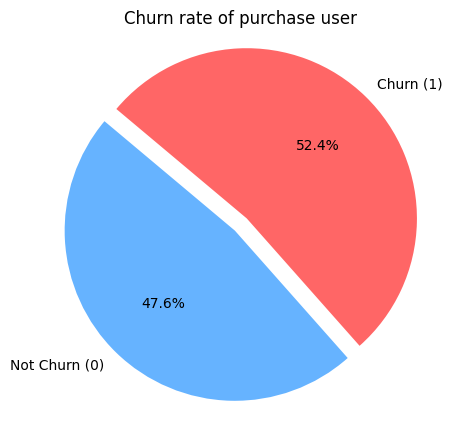

In [18]:
churn_counts = df_merged['churn'].value_counts().sort_index()
labels = ['Not Churn (0)', 'Churn (1)']
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(5,5))
plt.pie(
    churn_counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0, 0.1]  
)
plt.title("Churn rate of purchase user")
plt.axis('equal') 
plt.show()

In [20]:
drop_cols = [
    # 'last_update_time_purchase',
    'last_update_time_login',
    # 'days_since_last_purchase',
    'days_since_last_login',
]
df_merged=df_merged.drop(columns=drop_cols,axis=1)

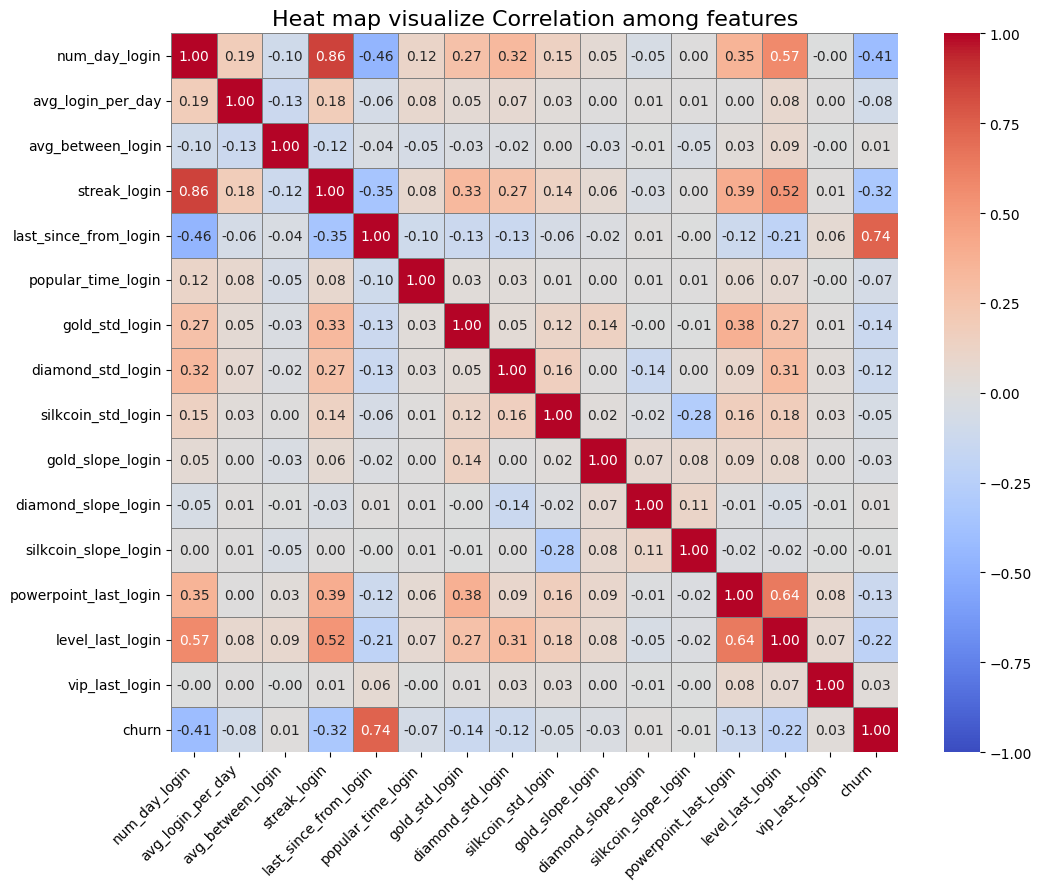

In [23]:
corr_cols = df_merged.drop(columns=['vopenid','equi_beha']).columns

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(11, 9))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",
    cmap="coolwarm",    
    vmin=-1,           
    vmax=1,
    center=0,        
    linewidths=0.5,     
    linecolor='gray' 
)

plt.title('Heat map visualize Correlation among features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# corr_matrix = df_merged[corr_cols].corr()
# corr_matrix

### **Prepare data**

In [24]:
X=df_merged.drop(columns=['churn','vopenid','last_since_from_login','powerpoint_last_login'],axis=1)
y=df_merged['churn']

In [25]:
vopenid_all = df_merged['vopenid']

In [26]:
le=LabelEncoder()
X['equi_beha']=le.fit_transform(X['equi_beha'])

In [27]:
X_train, X_test, y_train, y_test,vopenid_train, vopenid_test = train_test_split(
    X, y, vopenid_all,
    test_size=0.15,
    stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142176, 14), (25090, 14), (142176,), (25090,))

In [28]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [30]:
X_train_cb=X_train.copy()
y_train_cb=y_train.copy()
X_test_cb=X_test.copy()
y_test_cb=y_test.copy()
X_train_cb['equi_beha'] = X_train_cb['equi_beha'].astype(str)
X_test_cb['equi_beha'] = X_test_cb['equi_beha'].astype(str)

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [32]:
X_train.shape,y_train.shape, X_train_scaled.shape,X_test_scaled.shape

((148866, 14), (148866,), (148866, 14), (25090, 14))

### **Modeling**

#### **Logistic Regression**

In [33]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42
    }
    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-25 09:54:54,876] A new study created in memory with name: no-name-f102d993-c182-421a-add1-baf6caf88398
[I 2025-06-25 09:54:55,374] Trial 0 finished with value: 0.7450162585054728 and parameters: {'C': 0.0013064007858711757, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with value: 0.7450162585054728.
[I 2025-06-25 09:55:02,920] Trial 1 finished with value: 0.7479838680291901 and parameters: {'C': 0.08561901507626818, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7479838680291901.
[I 2025-06-25 09:55:03,636] Trial 2 finished with value: 0.7488514651051822 and parameters: {'C': 0.006076094147720333, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 2 with value: 0.7488514651051822.
[I 2025-06-25 09:55:10,093] Trial 3 finished with value: 0.7481438092990906 and parameters: {'C': 0.008068273483092301, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced'}. Best is 

Best AUC: 0.7490663523793475
  - C: 0.003594508360966004
  - penalty: l1
  - solver: liblinear
  - class_weight: None


In [34]:
best_params_lr = study.best_params
best_params_lr.update({
    'random_state': 42,
    'n_jobs': -1
})
lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.003594508360966004, n_jobs=-1, penalty='l1',
                   random_state=42, solver='liblinear')

In [35]:
y_test_pred  = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.6699
Precision: 0.6572
Recall: 0.7724
F1-score: 0.7102
AUC-ROC: 0.7486
Log loss: 0.5971
Brier score: 0.2066

Confusion matrix:
[[ 6663  5292]
 [ 2989 10146]]

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.56      0.62     11955
           1       0.66      0.77      0.71     13135

    accuracy                           0.67     25090
   macro avg       0.67      0.66      0.66     25090
weighted avg       0.67      0.67      0.67     25090



#### **Extra Trees**

In [36]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-25 09:55:52,263] A new study created in memory with name: no-name-2e9eeb18-65d4-4938-a407-d24e0203e85b
[I 2025-06-25 09:56:02,568] Trial 0 finished with value: 0.9011769313284208 and parameters: {'n_estimators': 458, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 0.8, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9011769313284208.
[I 2025-06-25 09:56:09,545] Trial 1 finished with value: 0.8912255329680396 and parameters: {'n_estimators': 332, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 0.8, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9011769313284208.
[I 2025-06-25 09:56:12,974] Trial 2 finished with value: 0.7923053090512038 and parameters: {'n_estimators': 381, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.9011769313284208.
[I 2025-06-25 09:56:16,737] Trial 3 finished with value:

Best value: 0.937432730642233
Best params:
  - n_estimators: 335
  - max_depth: 28
  - min_samples_split: 2
  - min_samples_leaf: 2
  - max_features: None
  - class_weight: None


In [37]:
best_params_et = study.best_params
best_params_et.update({
    'random_state': 42,
    'n_jobs': -1
})
et_model = ExtraTreesClassifier(**best_params_et)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=28, max_features=None, min_samples_leaf=2,
                     n_estimators=335, n_jobs=-1, random_state=42)

In [35]:
y_test_pred  = et_model.predict(X_test)
y_test_proba = et_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9246
Precision: 0.5798
Recall: 0.8094
F1-score: 0.6756
AUC-ROC: 0.9651
Log loss: 0.1564
Brier score: 0.0499

Confusion matrix:
[[4075  274]
 [  89  378]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4349
           1       0.58      0.81      0.68       467

    accuracy                           0.92      4816
   macro avg       0.78      0.87      0.82      4816
weighted avg       0.94      0.92      0.93      4816



#### **Random Forest**

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),            
        'max_depth': trial.suggest_int('max_depth', 10, 30),                     
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),     
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),      
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-25 10:00:22,156] A new study created in memory with name: no-name-6092b2fb-7b6d-436c-b623-f5d623018888


In [ ]:
best_params_rf = study.best_params
best_params_rf.update({
    'random_state': 42,
    'n_jobs': -1
})
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=30,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=20, n_estimators=471, n_jobs=-1,
                       random_state=42)

In [ ]:
y_test_pred  = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9338
Precision: 0.6412
Recall: 0.7195
F1-score: 0.6781
AUC-ROC: 0.9633
Log loss: 0.1578
Brier score: 0.0478

Confusion matrix:
[[4161  188]
 [ 131  336]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4349
           1       0.64      0.72      0.68       467

    accuracy                           0.93      4816
   macro avg       0.81      0.84      0.82      4816
weighted avg       0.94      0.93      0.94      4816



#### **Extreme Gradient Boosting**

In [ ]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,2,5,9.3,10]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best values", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-25 09:16:15,244] A new study created in memory with name: no-name-0b5398cc-fc00-4770-b6e5-dfd88d3e4796
[I 2025-06-25 09:16:15,981] Trial 0 finished with value: 0.990148145470094 and parameters: {'max_depth': 6, 'learning_rate': 0.06847185155161592, 'gamma': 2.671730610368062, 'min_child_weight': 6, 'colsample_bytree': 0.5445184866382105, 'subsample': 0.8570388445299526, 'reg_alpha': 0.3265584372530091, 'reg_lambda': 0.447651088179094, 'scale_pos_weight': 1, 'n_estimators': 160}. Best is trial 0 with value: 0.990148145470094.
[I 2025-06-25 09:16:17,586] Trial 1 finished with value: 0.9923600290613404 and parameters: {'max_depth': 12, 'learning_rate': 0.05330138323041764, 'gamma': 5.532657409046921, 'min_child_weight': 12, 'colsample_bytree': 0.9184944728924337, 'subsample': 0.8762693708861812, 'reg_alpha': 0.37399279129215884, 'reg_lambda': 0.26029036104403525, 'scale_pos_weight': 2, 'n_estimators': 492}. Best is trial 1 with value: 0.9923600290613404.
[I 2025-06-25 09:16:19,

Best values 0.9958383473643849
Best params:
  - max_depth: 12
  - learning_rate: 0.11418263578654844
  - gamma: 0.0034750658850715155
  - min_child_weight: 1
  - colsample_bytree: 0.9731709680418676
  - subsample: 0.7727482278206461
  - reg_alpha: 0.45889347826610755
  - reg_lambda: 0.4068895855283951
  - scale_pos_weight: 2
  - n_estimators: 291


In [ ]:
best_params_xgb = study.best_params
best_params_xgb.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'tree_method': 'hist'
})
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9731709680418676, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.0034750658850715155, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.11418263578654844, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=291, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_test_pred  = xgb_model.predict(X_test)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9367
Precision: 0.6620
Recall: 0.7088
F1-score: 0.6846
AUC-ROC: 0.9661
Log loss: 0.1700
Brier score: 0.0474

Confusion matrix:
[[4180  169]
 [ 136  331]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4349
           1       0.66      0.71      0.68       467

    accuracy                           0.94      4816
   macro avg       0.82      0.83      0.82      4816
weighted avg       0.94      0.94      0.94      4816



#### **Light Gradient Boosting Machine**

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5,9.3, 10]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-25 09:20:27,230] A new study created in memory with name: no-name-5e90b290-73e3-44e4-a2eb-32069be99f41
[I 2025-06-25 09:20:28,044] Trial 0 finished with value: 0.9918618446539258 and parameters: {'n_estimators': 407, 'learning_rate': 0.2771511249627751, 'max_depth': 4, 'num_leaves': 66, 'min_child_samples': 8, 'min_split_gain': 0.5740774253048805, 'subsample': 0.9405764312310869, 'colsample_bytree': 0.8938840041174471, 'reg_alpha': 0.4480586990550245, 'reg_lambda': 0.29973089715260093, 'scale_pos_weight': 1, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9918618446539258.
[I 2025-06-25 09:20:30,217] Trial 1 finished with value: 0.9928442378694763 and parameters: {'n_estimators': 296, 'learning_rate': 0.03322891502870157, 'max_depth': 9, 'num_leaves': 250, 'min_child_samples': 92, 'min_split_gain': 0.04288432820975285, 'subsample': 0.7024713053125295, 'colsample_bytree': 0.7140308000803817, 'reg_alpha': 0.06598132340231055, 'reg_lambda': 0.2801157736915264, 'scale

Best value: 0.9957414281893024
Best params:
  - n_estimators: 346
  - learning_rate: 0.05770353458931832
  - max_depth: 12
  - num_leaves: 248
  - min_child_samples: 34
  - min_split_gain: 0.0001914484065460645
  - subsample: 0.9867205505930825
  - colsample_bytree: 0.803467564895187
  - reg_alpha: 0.02400112818988486
  - reg_lambda: 0.18849125719650883
  - scale_pos_weight: 5
  - class_weight: balanced


In [ ]:
best_params_lgbm = study.best_params
best_params_lgbm.update({
    'random_state': 42,
    'n_jobs': -1
})
lgbm_model = LGBMClassifier(**best_params_lgbm)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.803467564895187,
               learning_rate=0.05770353458931832, max_depth=12,
               min_child_samples=34, min_split_gain=0.0001914484065460645,
               n_estimators=346, n_jobs=-1, num_leaves=248, random_state=42,
               reg_alpha=0.02400112818988486, reg_lambda=0.18849125719650883,
               scale_pos_weight=5, subsample=0.9867205505930825)

In [ ]:
y_test_pred  = lgbm_model.predict(X_test)
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9346
Precision: 0.6377
Recall: 0.7537
F1-score: 0.6909
AUC-ROC: 0.9669
Log loss: 0.1671
Brier score: 0.0492

Confusion matrix:
[[4149  200]
 [ 115  352]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4349
           1       0.64      0.75      0.69       467

    accuracy                           0.93      4816
   macro avg       0.81      0.85      0.83      4816
weighted avg       0.94      0.93      0.94      4816



#### **CatBoost**

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 600),
        'depth': trial.suggest_int('depth', 5, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.15),
        'random_seed': 42,
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', None]),
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train_cb, y_train_cb, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f" - {k}: {v}")


[I 2025-06-25 09:29:27,718] A new study created in memory with name: no-name-e851894b-740f-4e0f-ad25-de10736cf312
[I 2025-06-25 09:29:46,343] Trial 0 finished with value: 0.9938624636321471 and parameters: {'iterations': 522, 'depth': 7, 'learning_rate': 0.1396487925844278, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.9938624636321471.
[I 2025-06-25 09:30:01,181] Trial 1 finished with value: 0.9921045193645639 and parameters: {'iterations': 337, 'depth': 8, 'learning_rate': 0.051559432348401456, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.9938624636321471.
[I 2025-06-25 09:30:16,921] Trial 2 finished with value: 0.9930859407941895 and parameters: {'iterations': 362, 'depth': 8, 'learning_rate': 0.06735354878016744, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.9938624636321471.
[I 2025-06-25 09:30:30,236] Trial 3 finished with value: 0.9918704589596686 and parameters: {'iterations': 304, 'depth': 8, 'learning_rate': 0.05209975

Best value: 0.9941698444615449
Best params:
 - iterations: 515
 - depth: 8
 - learning_rate: 0.11394312441955987
 - auto_class_weights: Balanced


In [ ]:
best_params_cb = study.best_params
best_params_cb.update({
    'random_seed': 42,
    'verbose': 0
})

catboost_model = CatBoostClassifier(**best_params_cb, cat_features=['equi_beha'])
catboost_model.fit(X_train_cb, y_train_cb)

In [ ]:
y_test_pred_cb = catboost_model.predict(X_test_cb)
y_test_proba_cb = catboost_model.predict_proba(X_test_cb)[:, 1]

print(f"Accuracy: {accuracy_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"Precision: {precision_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"Recall: {recall_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"F1-score: {f1_score(y_test_cb, y_test_pred_cb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test_cb, y_test_proba_cb):.4f}")
print(f"Log loss: {log_loss(y_test_cb, y_test_proba_cb):.4f}")
print(f"Brier score: {brier_score_loss(y_test_cb, y_test_proba_cb):.4f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test_cb, y_test_pred_cb))
print("\nClassification report:")
print(classification_report(y_test_cb, y_test_pred_cb))

Accuracy: 0.9363
Precision: 0.6653
Recall: 0.6895
F1-score: 0.6772
AUC-ROC: 0.9637
Log loss: 0.1455
Brier score: 0.0449

Confusion matrix:
[[4187  162]
 [ 145  322]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4349
           1       0.67      0.69      0.68       467

    accuracy                           0.94      4816
   macro avg       0.82      0.83      0.82      4816
weighted avg       0.94      0.94      0.94      4816



#### **Voting Classifier**

In [ ]:
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(**best_params_lr)
)
et_model = ExtraTreesClassifier(**best_params_et)
rf_model = RandomForestClassifier(**best_params_rf)
xgb_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm)
cb_model = make_pipeline(
    FunctionTransformer(lambda X: X.assign(equip_beha=X['equi_beha'].astype(str))),
    CatBoostClassifier(**best_params_cb, cat_features=['equi_beha'])
)

In [ ]:
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('et',et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cb',cb_model),
    ],
    voting='soft' 
)

voting_model.fit(X_train, y_train)  

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=1.1666662881289005,
                                                                  n_jobs=-1,
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('et',
                              ExtraTreesClassifier(class_weight='balanced',
                                                   max_depth=30,
                                                   max_features=0.8,
                                                   min_samples_leaf=3,
                                                   min_samples_split=8,
                                                   n_estimators=427, n_jobs=-1,
                                                   rand...
                                             num_leaves=248, random_state=42,
                                             reg_alpha=0.02400112818988486,
                                             reg_lambda=0.18849125719650883,
                                             scale_pos_weight=5,
                                             subsample=0.9867205505930825)),
                             ('cb',
                              Pipeline(steps=[('functiontransformer',
                                               FunctionTransformer(func=<function <lambda> at 0x000002B1BBF3A0C0>)),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x000002B168DC7680>)]))],
                 voting='soft')

In [ ]:
y_test_proba_voting = voting_model.predict_proba(X_test)[:, 1]
y_test_pred_voting  = voting_model.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_voting):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_voting):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_voting):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_voting):.4f}")
print(f"Log Loss: {log_loss(y_test, y_test_proba_voting):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_test_proba_voting):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_voting))

Accuracy: 0.9356
Precision: 0.6451
Recall: 0.7473
F1-score: 0.6925
AUC-ROC: 0.9630
Log Loss: 0.1787
Brier Score: 0.0482

Confusion Matrix:
[[4157  192]
 [ 118  349]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4349
           1       0.65      0.75      0.69       467

    accuracy                           0.94      4816
   macro avg       0.81      0.85      0.83      4816
weighted avg       0.94      0.94      0.94      4816



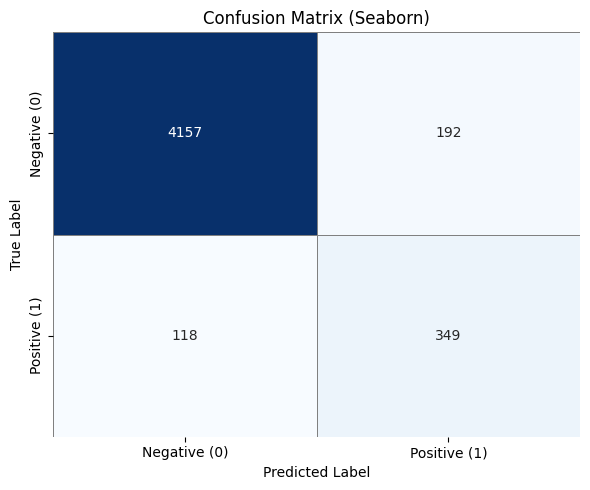

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_voting)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

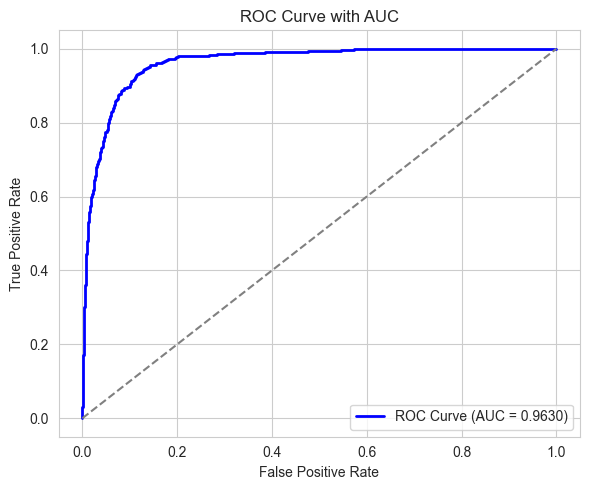

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_voting)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#### **Stacking Classifier**

In [ ]:
stacking_model = StackingClassifier(
    estimators=[
        ('lr',lr_model),
        ('et', et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('cb',cb_model),
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)
    
stacking_model.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(C=1.1666662881289005,
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    solver='liblinear'))])),
                               ('et',
                                ExtraTreesClassifier(class_weight='balanced',
                                                     max_depth=30,
                                                     max_features=0.8,
                                                     min_samples_leaf=3,
                                                     min_samples_split=8,
                                                     n_estimators=427,
                                                     n_jobs=...
                                               reg_lambda=0.18849125719650883,
                                               scale_pos_weight=5,
                                               subsample=0.9867205505930825)),
                               ('cb',
                                Pipeline(steps=[('functiontransformer',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002B1BBF3A0C0>)),
                                                ('catboostclassifier',
                                                 <catboost.core.CatBoostClassifier object at 0x000002B168DC7680>)]))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1)

In [ ]:
y_test_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]
y_test_pred_stacking  = stacking_model.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_stacking):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_stacking):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_stacking):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_stacking):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_stacking):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba_stacking):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba_stacking):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred_stacking))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred_stacking))

Accuracy: 0.9398
Precision: 0.6788
Recall: 0.7195
F1-score: 0.6985
AUC-ROC: 0.9667
Log loss: 0.1541
Brier score: 0.0462

Confusion matrix:
[[4190  159]
 [ 131  336]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4349
           1       0.68      0.72      0.70       467

    accuracy                           0.94      4816
   macro avg       0.82      0.84      0.83      4816
weighted avg       0.94      0.94      0.94      4816



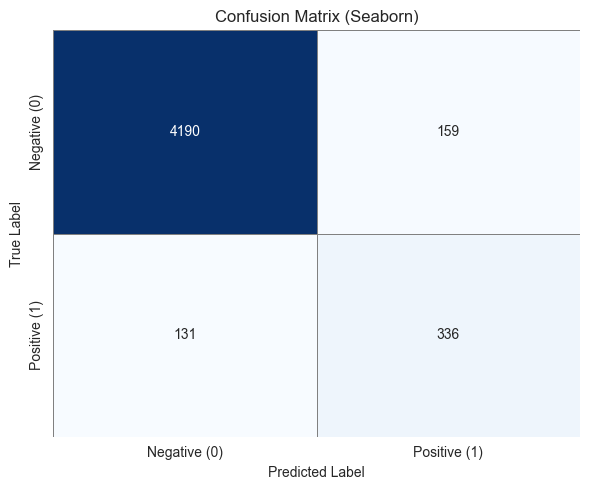

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_stacking)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

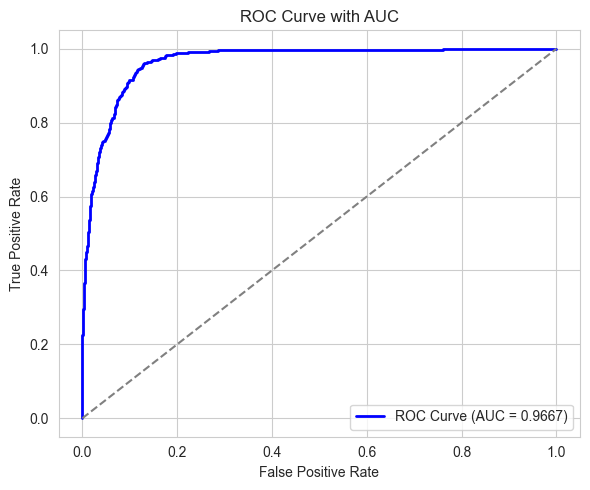

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_stacking)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
